In [27]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
api_key = '36N2WM8I8W74IFZ0'

In [3]:
ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='TSLA', outputsize = 'full')
data = data.reindex(index=data.index[::-1])
print(data)

            1. open   2. high  3. low  4. close   5. volume
date                                                       
2010-06-29    19.00   25.0000   17.54     23.89  18766300.0
2010-06-30    25.79   30.4192   23.30     23.83  17187100.0
2010-07-01    25.00   25.9200   20.27     21.96   8218800.0
2010-07-02    23.00   23.1000   18.71     19.20   5139800.0
2010-07-06    20.00   20.0000   15.83     16.11   6866900.0
...             ...       ...     ...       ...         ...
2021-05-21   596.11  596.6800  580.00    580.88  26030595.0
2021-05-24   581.60  614.4800  573.65    606.44  34558089.0
2021-05-25   607.31  613.9900  595.71    604.69  28005933.0
2021-05-26   607.56  626.1700  601.50    619.13  28639305.0
2021-05-27   620.24  631.1300  616.21    630.85  26201264.0

[2748 rows x 5 columns]


In [4]:
close_data = data['4. close'][len(data)-1000:len(data)]
print (close_data)

date
2017-06-08    370.00
2017-06-09    357.32
2017-06-12    359.01
2017-06-13    375.95
2017-06-14    380.66
               ...  
2021-05-21    580.88
2021-05-24    606.44
2021-05-25    604.69
2021-05-26    619.13
2021-05-27    630.85
Name: 4. close, Length: 1000, dtype: float64


<AxesSubplot:xlabel='date'>

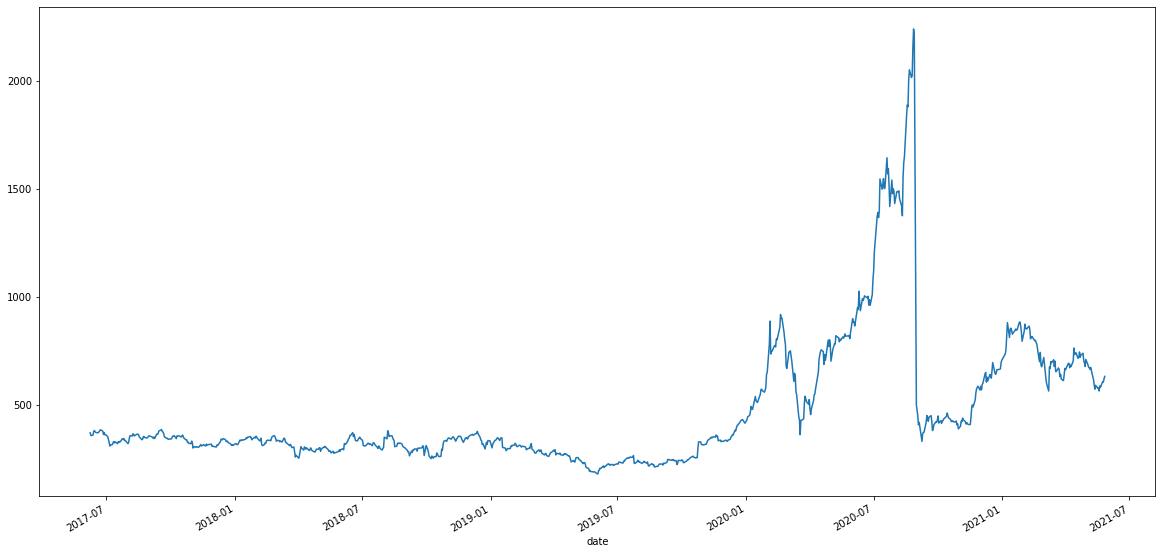

In [5]:
close_data.plot(figsize=(20,10))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))

In [7]:
prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
29/29 [==============================] - 8s 114ms/step - loss: 0.0204
Epoch 2/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0061
Epoch 3/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0063
Epoch 4/25
29/29 [==============================] - 3s 112ms/step - loss: 0.0040
Epoch 5/25
29/29 [==============================] - 3s 112ms/step - loss: 0.0051
Epoch 6/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0056
Epoch 7/25
29/29 [==============================] - 3s 114ms/step - loss: 0.0028
Epoch 8/25
29/29 [==============================] - 3s 112ms/step - loss: 0.0032
Epoch 9/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0038
Epoch 10/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0050
Epoch 11/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0017
Epoch 12/25
29/29 [==============================] - 3s 111ms/step - loss: 0.0023
Epoch 13/25
29/29 [======

In [10]:
predicted_prices = model.predict(x_train)
predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = data['4. close'][len(data)-1000:len(data)].values

for x in range(0, prediction_days+1):
    actual_prices = np.delete(actual_prices, 0)

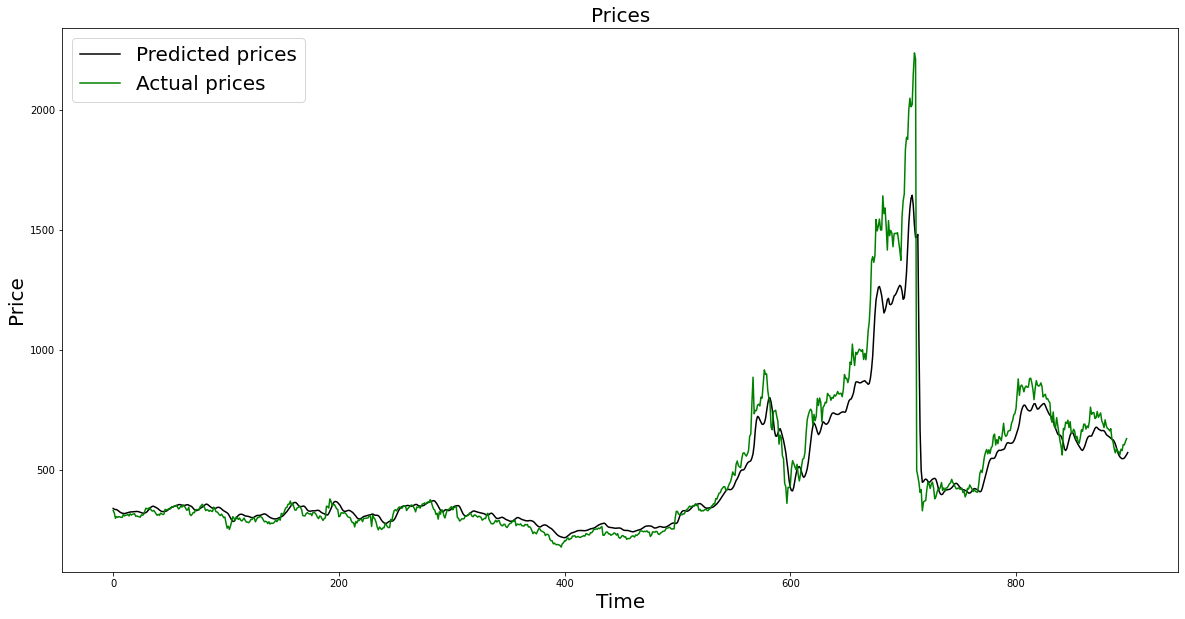

In [11]:
plt.figure(figsize=(20,10))
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_prices, color="green", label="Actual prices")
plt.title(f'Prices', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [32]:
new_data, new_meta_data = ts.get_daily(symbol='MSFT', outputsize = 'full')
new_data = new_data.reindex(index=data.index[::-1])
new_close_data = new_data['4. close'][len(new_data)-1000:len(new_data)]

new_scaled_data = scaler.fit_transform(new_close_data.values.reshape(-1,1))

x_test = []

prediction_days = 100

for x in range(prediction_days, len(new_scaled_data)):
    x_test.append(new_scaled_data[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

In [33]:
actual_new_prices = new_data['4. close'][len(new_data)-1000:len(new_data)].values

for x in range(0, prediction_days+1):
    actual_new_prices = np.delete(actual_new_prices, 0)

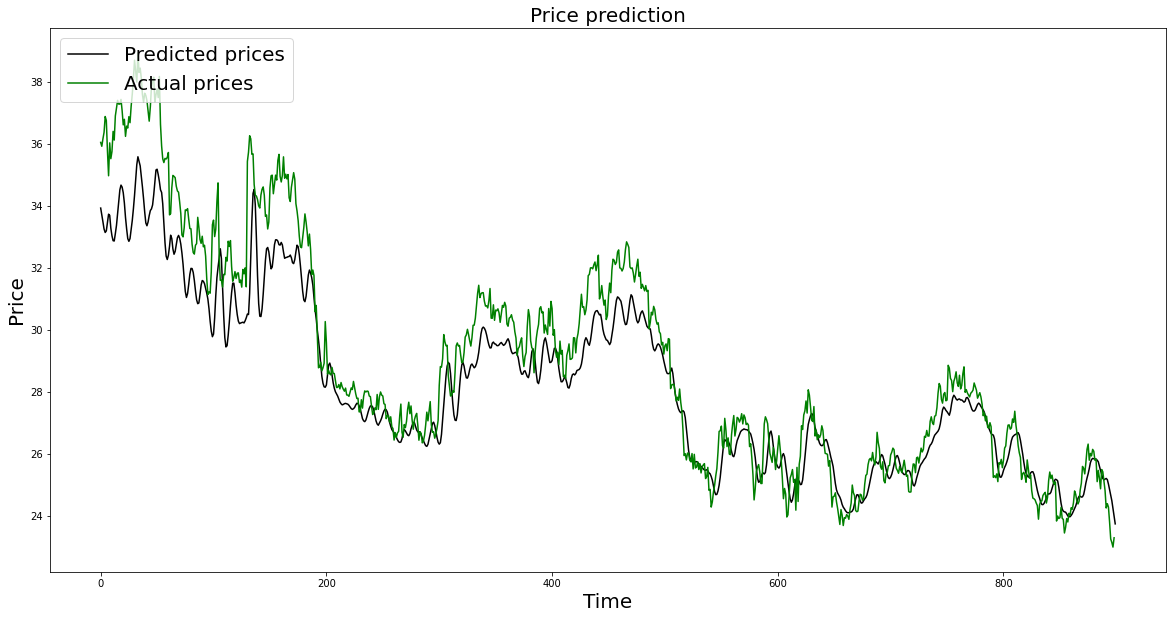

In [34]:
plt.figure(figsize=(20,10))
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_new_prices, color="green", label="Actual prices")
plt.title(f'Price prediction', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [26]:
print(predicted_prices[len(predicted_prices)-1][0])

23.758366


In [28]:
model.save('my_model.h5')

In [29]:
del model

In [31]:
model = load_model('my_model.h5')